In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rc('font', family="serif")
plt.rc('font', size=16)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
plt.rc('figure', figsize=(6,4)) 

In [3]:
import jax
from jax import (
    jit as jjit,
    numpy as jnp,
    vmap,
    grad,
    random as jran,
)

from jax.example_libraries import stax, optimizers
import numpy as np
import time

# Training a Neural Network

In [13]:
# Set a random seed for reproducibility
seed = 1291
jran = jax.random  # Alias for jax.random
key = jran.PRNGKey(seed=seed)  # Initialize the PRNG key with the seed

# Define the number of input features and target outputs
n_features, n_targets = 3, 30

# Define a feedforward neural network using stax
net_init, net_apply = stax.serial(
    stax.Dense(n_features), stax.Selu,  # First layer: n_features neurons with SELU activation
    stax.Dense(16), stax.Relu,          # Hidden layer: 16 neurons, ReLU activation
    stax.Dense(64), stax.Relu,          # Hidden layer: 64 neurons, ReLU activation
    stax.Dense(32), stax.Relu,          # Hidden layer: 32 neurons, ReLU activation
    stax.Dense(16), stax.Relu,          # Hidden layer: 16 neurons, ReLU activation
    stax.Dense(n_targets),              # Output layer: n_targets neurons (no activation)
)

# Split the random key for network initialization
key, subkey = jran.split(key)

# Initialize network parameters
out_shape, net_params = net_init(subkey, input_shape=(-1, n_features))

# Define the learning rate for the Adam optimizer
learning_rate = 1e-3

# Initialize the Adam optimizer
opt_init, opt_update, get_params = optimizers.adam(learning_rate)

# Create the initial optimizer state using the network parameters
opt_state = opt_init(net_params)



In [ ]:
# Create a loss function to optimize the predictions of the NN
@jjit
def mse_loss(params, batch, targets):
    preds = net_apply(params, batch)
    diff = preds - targets 
    return jnp.mean(diff * diff)


mse_loss_grad = jjit(grad(mse_loss, argnums=0))

@jjit
def train_step(step_i, opt_state, batch, targets):

    net_params = get_params(opt_state)
    loss = mse_loss(net_params, batch, targets)
    grads = mse_loss_grad(net_params, batch, targets)
    
    return loss, opt_update(step_i, grads, opt_state)

In [ ]:
# Create a silly toy model to target.
@jjit
def true_model(x, params):
    a, b, c = params
    return a + b * x + c * x ** 2

_fun = jjit(vmap(true_model, in_axes=[0, None]))
true_model_vmap = jjit(vmap(_fun, in_axes=[None, 0]))

(100, 3)
(100, 30)


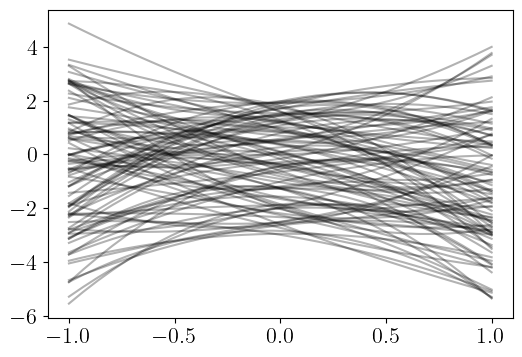

In [16]:
t = jnp.linspace(-1, 1, n_targets)

n_train = int(1e2)
train_params = np.random.uniform(-3.0, 2.0, (n_train, 3))
train_obs = true_model_vmap(t, train_params)
print(train_params.shape)
print(train_obs.shape)

plt.plot(t, train_obs.T, color='k', alpha=0.3)
plt.show()

In [17]:
# Store loss values during training
loss_history = []

num_epoch = 50_000
batch_size = 200
num_batches = int(len(train_params)/batch_size)

arr = np.arange(len(train_params))

for epoch in range(num_epoch):
    # start = time.time()

    train_params = np.random.uniform(-3.0, 2.0, (n_train, 3))
    train_obs = true_model_vmap(t, train_params)
    
    loss, opt_state = train_step(len(loss_history), opt_state, train_params, train_obs)

    loss_history.append(loss.item())
        
    # end = time.time()
    # msg = "training time for {0} iterations = {1:.1f} seconds"
    # print(epoch, msg.format(num_batches, end-start))


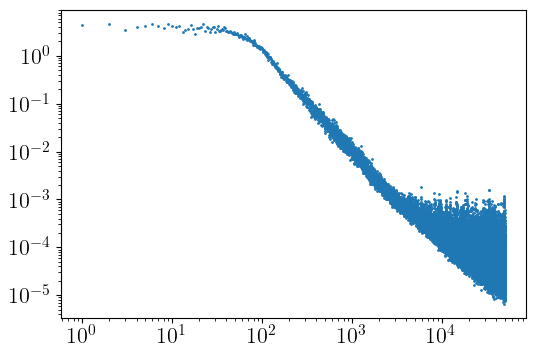

In [18]:
fig, ax = plt.subplots(1, 1)
# xlim = ax.set_xlim(1, 5e6)
__=ax.loglog()
__=ax.scatter(range(1, 1+len(loss_history)), loss_history, s=1)
plt.show()

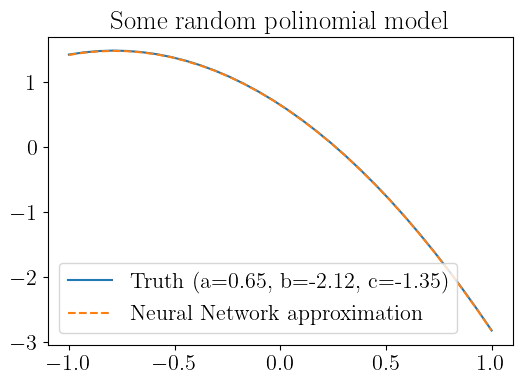

In [19]:
net_params = get_params(opt_state)

train_params = np.random.uniform(-3.0, 2.0, (1, 3))

net_prediction = net_apply(net_params, train_params)[0]

true_prediction = true_model(t, train_params[0])

a,b,c = train_params[0]

plt.plot(t, true_prediction, label=r'Truth (a=%.2f, b=%.2f, c=%.2f)'%(a,b,c))
plt.plot(t, net_prediction, ls='--', label='Neural Network approximation')
plt.legend()
plt.title("Some random polinomial model")
plt.show()